In [1]:
import hashlib
import os
import requests
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import urllib.request
import numpy as np
import pandas as pd

In [4]:
pan_dulce_types = {'conchita': ['conchita', 'concha'],
                    'quequito': ['quequito',
                    'mantecada',
                    'mantecada de chocolate',
                    'quequito de chocolate'],
                    'puerquito': ['puerquito', 'cochinito', 'marranito', 'puerco'],
                    'elote': ['elote', 'elotito'],
                    'barquillo': ['barquillo', 'cono de crema'],
                    'orejas': ['orejas', 'orejitas'],
                    'pan-de-muerto': ['pan de muerto'],
                    'rosca-de-reyes': ['rosca de reyes'],
                    'donas': ['donas'],
                    'cuernitos': ['cuernitos', 'cuerno'],
                    'chilindrina': ['chilindrina', 'chilindrinas'],
                    'besos': ['besos', 'besitos', 'ojo de buey', 'yoyos'],
                    'niño-envuelto': ['niño envuelto']}

In [5]:
subscription_key = input('Enter your subscription key: ')
search_url = "https://api.bing.microsoft.com/v7.0/images/search"
headers = {"Ocp-Apim-Subscription-Key" : subscription_key}

In [ ]:
for pan, names in pan_dulce_types.items():
    directory = 'dataset/' + pan
    print(f'Creating {directory}')
    if not os.path.isdir(directory):
        os.makedirs(directory)
    
    queries = [name + ' pan dulce' for name in names]
    for n, query in enumerate(queries):
        nimages = 5 - len(queries)
        for i in range(nimages):
            print(f'Getting {query} images {i * 50 + 1} to {(i + 1) * 50 }')
            params  = {'q': query, 'count': 50, 'offset': i * 50}
            response = requests.get(search_url, headers=headers, params=params)
            response.raise_for_status()
            search_results = response.json()
            thumbnail_urls = [img["thumbnailUrl"] for img in search_results["value"]]
            for j, url in enumerate(thumbnail_urls):
                try:
                    urllib.request.urlretrieve(url, directory + '/' + pan + '-'+ str(j + i * 150 + n*300) + ".jpg")
                except:
                    pass

    hashes = set()
    print(f'Removing duplicates in {directory}')
    for filename in os.listdir(directory):
        path = os.path.join(directory, filename)
        digest = hashlib.sha1(open(path,'rb').read()).digest()
        if digest not in hashes:
            hashes.add(digest)
            os.rename(path, directory + '/' + filename)
        else:
            os.remove(path)
    print(f'Finished {directory}\n')

In [55]:
# Code to rename all images in a directory
directory = 'dataset'
df = pd.DataFrame(columns=['filename', 'label'])
# Convert labels to integers with dictionary
labels = {}

for i, folder in enumerate(os.listdir(directory)):
    labels[folder] = i
    for j, filename in enumerate(os.listdir(directory + '/' + folder)):
        #os.rename(directory + '/' + folder + '/' + filename, directory + '/' + folder + '/' + folder + '_' + str(ji) + '.jpg')
        df = pd.concat([df, pd.DataFrame({'filename': folder + '/' + folder + '_' + str(j) + '.jpg', 'label': labels[folder]}, index = [0])], axis=0)

df.to_csv('pan_dulce.csv', index=False)

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import PIL
from pan_dulce_dataset import PanDulceDataset
from sklearn.model_selection import train_test_split
from skimage import io

In [107]:
image_transforms = { 
    'train': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(256), 
        transforms.RandomCrop(224),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5],
                             [0.5, 0.5, 0.5])
    ]),
    'test': transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5),
                                     (0.5, 0.5, 0.5))])}

train_dataset = PanDulceDataset(csv_file='pan_dulce.csv',
                            root_dir='dataset',
                            transform= image_transforms['train'])

test_dataset = PanDulceDataset(csv_file='pan_dulce.csv',
                            root_dir='dataset',
                            transform= image_transforms['test'])

val_dataset = PanDulceDataset(csv_file='pan_dulce.csv',
                            root_dir='dataset',
                            transform= image_transforms['test'])

classes = ('barquillo', 'besos', 'chilindrina', 'conchita', 'cuernitos',
            'donas', 'elote', 'niño-envuelto', 'orejas', 'pan-de-muerto',
            'puerquito', 'quequito', 'rosca-de-reyes')

In [118]:
num_train = len(train_dataset)
indices = list(range(num_train))
np.random.shuffle(indices)

split_test = int(np.floor(0.2 * num_train))
split_val = int(np.floor(0.2 * (num_train - split_test)))

train_indices, test_indices = indices[split_test:], indices[:split_test]
train_indices, val_indices = train_indices[split_val:], train_indices[:split_val]

train_dataset = torch.utils.data.Subset(train_dataset, train_indices)
test_dataset = torch.utils.data.Subset(test_dataset, test_indices)
val_dataset = torch.utils.data.Subset(val_dataset, val_indices)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)

print(f'Train size: {len(train_loader.dataset)}')
print(f'Validation size: {len(val_loader.dataset)}')
print(f'Test size: {len(test_loader.dataset)}')

Train size: 1165
Validation size: 291
Test size: 364


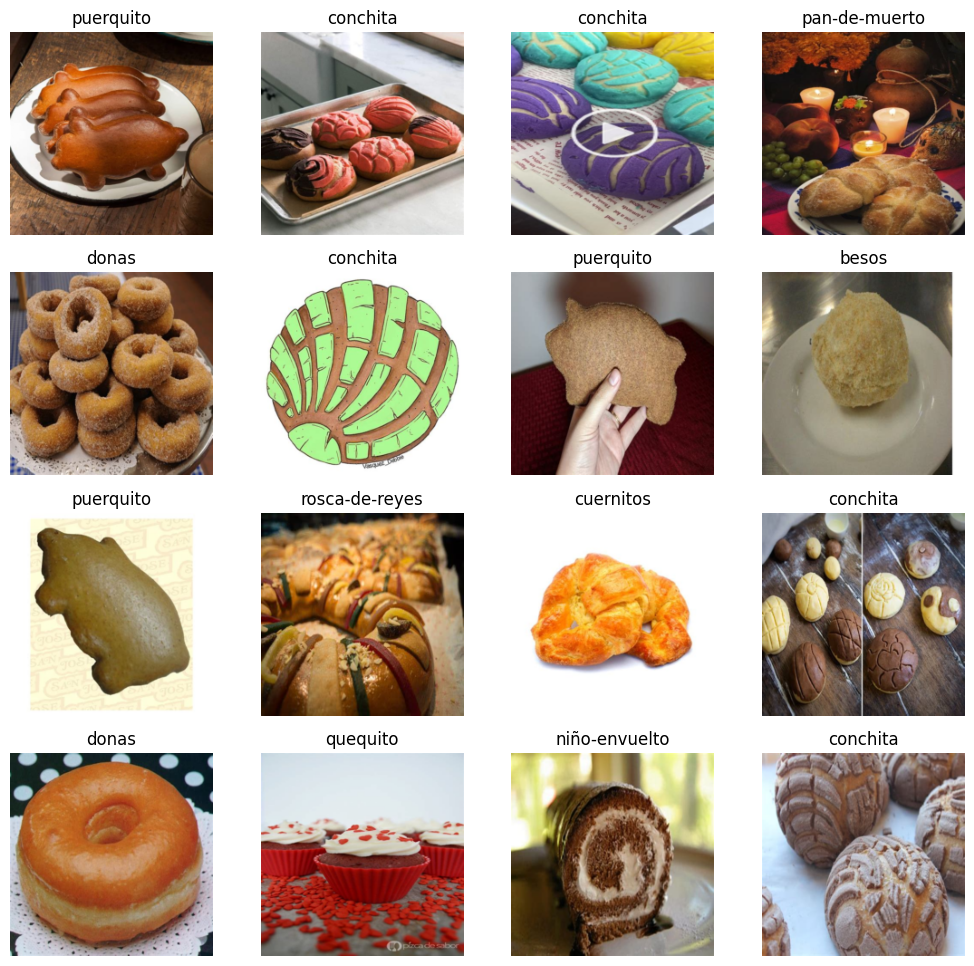

In [10]:
# view some images in training set
import matplotlib.pyplot as plt
import numpy as np

batch_X, batch_Y =  next(iter(test_loader))

plt.figure(figsize=(10,10))
for i in range(4):
    for j in range(4):
        plt.subplot(4,4,i*4+j+1)
        plt.tight_layout()
        plt.imshow((batch_X[i*4+j].permute(1, 2, 0))/2 + 0.5)
        plt.title(classes[batch_Y[i*4+j]])
        plt.axis('off')
plt.show()

In [146]:
# Define the model
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

model = torchvision.models.resnet18(weights = 'DEFAULT')
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(512, 13)

summary(model, (3, 224, 224))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\firul/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:23<00:00, 1.95MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [147]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [148]:
# Define training loop:
import time
def fit(model, train_loader, val_loader, criterion, optimizer, epochs=10, device='cpu'):
    start = time.time()
    print(f'Running training loop on {device}')
    history = []
    best_acc = 0.0
    for epoch in range(epochs):
        epoch_start = time.time()
        print(f'Epoch: {epoch + 1}/{epochs}')
        model.train()

        train_loss = 0.0
        train_acc = 0.0
        val_loss = 0.0
        val_acc = 0.0

        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            train_acc += acc.item() * inputs.size(0)
            print(f'Batch: {i+1}/{len(train_loader)}', end='\r')
        
        with torch.no_grad():
            model.eval()
            for j, (inputs, labels) in enumerate(val_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))
                acc = torch.mean(correct_counts.type(torch.FloatTensor))
                val_acc += acc.item() * inputs.size(0)
        
        avg_train_loss = train_loss/len(train_loader.dataset)
        avg_train_acc = train_acc/len(train_loader.dataset)
        avg_val_loss = val_loss/len(val_loader.dataset)
        avg_val_acc = val_acc/len(val_loader.dataset)
        history.append([avg_train_loss, avg_val_loss, avg_train_acc, avg_val_acc])
        print(f'train loss: {avg_train_loss:.4f}, train acc: {avg_train_acc:.4f}, val loss: {avg_val_loss:.4f}, val acc: {avg_val_acc:.4f}, time: {time.time() - epoch_start:.2f}s')

        if avg_val_acc > best_acc:
            best_acc = avg_val_acc
            torch.save(model.state_dict(), 'best_checkpoint.model')
    
    return model, history

In [149]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 10
trained_model, history = fit(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)

Running training loop on cpu
Epoch: 1/10
train loss: 2.2979, train acc: 0.2498, val loss: 1.9624, val acc: 0.3677, time: 220.37s
Epoch: 2/10
train loss: 1.7308, train acc: 0.5227, val loss: 1.5830, val acc: 0.5017, time: 168.96s
Epoch: 3/10
train loss: 1.4252, train acc: 0.6386, val loss: 1.2504, val acc: 0.6460, time: 148.22s
Epoch: 4/10
train loss: 1.2860, train acc: 0.6283, val loss: 1.1315, val acc: 0.6770, time: 147.28s
Epoch: 5/10
train loss: 1.1375, train acc: 0.6867, val loss: 1.0306, val acc: 0.6942, time: 148.74s
Epoch: 6/10
train loss: 1.0521, train acc: 0.7039, val loss: 0.9989, val acc: 0.7113, time: 146.97s
Epoch: 7/10
train loss: 0.9564, train acc: 0.7451, val loss: 0.9763, val acc: 0.7079, time: 192.48s
Epoch: 8/10


KeyboardInterrupt: 

In [153]:
torch.cuda.is_available()

False